Name of Satellite: 

NORAD name: 49155
Celestrak name: STARLINK-3060 

TLE as of 19/12/23:

    1 49155U 21082AB  23352.82880271  .00000911  00000-0  84156-4 0  9997
    2 49155  69.9995 141.4506 0002692 260.7664  99.3190 14.98335501126430

In [1]:
from skyfield.api import Topos, load, EarthSatellite
import matplotlib.pyplot as plt
from skyfield.api import Time
from datetime import datetime, timedelta
import numpy as np
import sys
import pytz
import math
from math import pow
from math import radians
import astropy.time
import astropy.coordinates
import lumos.calculator
import lumos.conversions

sys.path.append('/Users/physarah/Development/satellite-optical-brightness/analysis')


import satellite_models.diffuse_sphere as diffuse_sphere
import satellite_models.starlink_v1p5 as starlink_v1p5
%matplotlib inline

In [2]:
tle_line1 = "STARLINK-3060"
tle_line2 = "1 49155U 21082AB  23352.82880271  .00000911  00000-0  84156-4 0  9997"
tle_line3 = "2 49155  69.9995 141.4506 0002692 260.7664  99.3190 14.98335501126430"

ts = load.timescale()
satellite = EarthSatellite(tle_line2, tle_line3, name="STARLINK-3060")        
observer_location = Topos('33.7703 S', '151.1112 E', elevation_m=70) # Macquarie Observatory

In [28]:
def generate_datetime_range(start_time, end_time, interval, time_delta):
    """
    Generate a list of datetimes between start_time and end_time at a given interval.
    """
    current_time = start_time
    datetime_list = []

    while current_time <= end_time:
        datetime_list.append(current_time + timedelta(hours = time_delta))
        current_time += interval

    return datetime_list

start_time = datetime(2023, 12, 19, 16, 20, 0)  # Replace with your start time
end_time = datetime(2023, 12, 19, 16, 47, 0)    # Replace with your end time
time_interval = timedelta(seconds=15)           # Replace with your desired interval

result1 = generate_datetime_range(start_time, end_time, time_interval, time_delta=11)
result2 = generate_datetime_range(start_time, end_time, time_interval, time_delta=0)

local_datetime = np.array(result2)
utc_datetime = np.array(result1)

sat_height = np.array([(570 + 540)/2]*len(utc_datetime) * 1000)

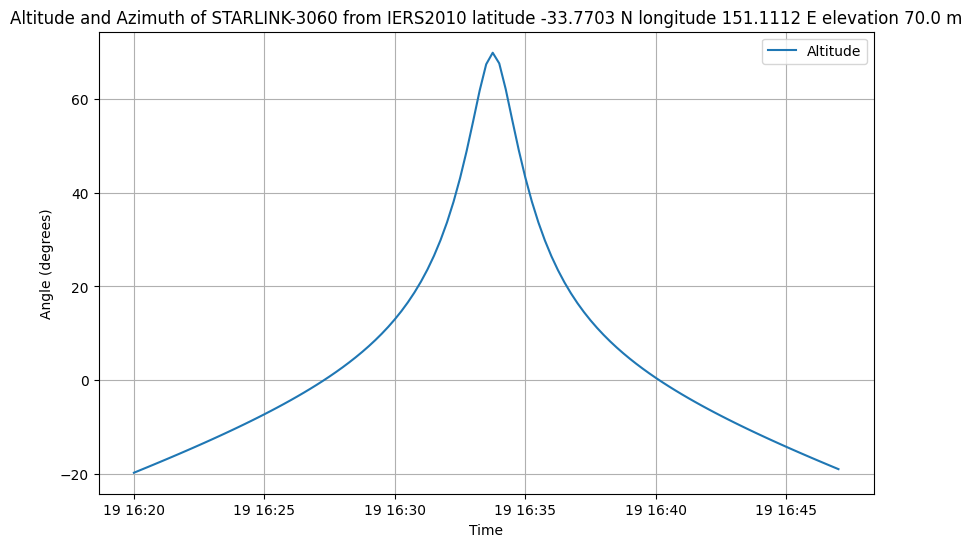

In [29]:
times = []
for timestamp_pd in local_datetime:
    TIME_PD = timestamp_pd.replace(tzinfo=pytz.utc)
    time_sf = ts.utc(TIME_PD)
    times.append(time_sf)

altitudes = []
azimuths = []
sep_angle = []
distance_list = []

for time in times:
    topocentric = (satellite - observer_location).at(time)
    satellite_position = satellite.at(time)
    satellite_position = satellite.at(time)

    observer_latitude = radians(-33.7703)  # Convert to radians
    observer_longitude = radians(151.1112)  # Convert to radians
    
    earth_radius_km = 6371.0  # Approximate Earth radius in kilometers

    delta_longitude = satellite_position.subpoint().longitude.radians - observer_longitude
    delta_latitude = satellite_position.subpoint().latitude.radians - observer_latitude

    a = (pow(math.sin(delta_latitude / 2), 2) +
         math.cos(observer_latitude) * math.cos(satellite_position.subpoint().latitude.radians) *
         pow(math.sin(delta_longitude / 2), 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance_km = earth_radius_km * c
    distance_list.append(distance_km)

    alt, az, _ = topocentric.altaz()
    altitudes.append(alt.degrees)
    azimuths.append(az.degrees)
    
times_datetime = [t.utc_datetime() for t in times]

plt.figure(figsize=(10, 6))
plt.plot(times_datetime, altitudes, label="Altitude")
#plt.plot(times_datetime, azimuths, label="Azimuth")
plt.xlabel("Time")
plt.ylabel("Angle (degrees)")
plt.legend()
plt.title(f"Altitude and Azimuth of {satellite.name} from {observer_location}")
plt.grid()
plt.show()

In [30]:
satellite_heights = sat_height
observation_times = [dt.isoformat() for dt in utc_datetime]
satellite_altitudes = altitudes
satellite_azimuths = azimuths
measured_magnitudes = np.random.rand(len(satellite_azimuths))

In [31]:
mount_lemmon = astropy.coordinates.EarthLocation(lat = -33.7703, lon = 151.1112)

In [32]:
intensities_diffuse_sphere = np.zeros_like(measured_magnitudes)
intensities_lab_brdfs = np.zeros_like(measured_magnitudes)
intensities_inferred_brdfs = np.zeros_like(measured_magnitudes)

sun_alt_list, sun_az_list = ([],[])
for i, (sat_alt, sat_az, sat_h, time) in \
    enumerate(zip(satellite_altitudes, satellite_azimuths, satellite_heights, observation_times)):
    
    observation_time = astropy.time.Time(time, format = 'isot')
    sun_alt, sun_az = lumos.calculator.get_sun_alt_az(observation_time, mount_lemmon)
    sun_alt_list.append(sun_alt)
    sun_az_list.append(sun_az)
        
    intensities_diffuse_sphere[i] = \
        diffuse_sphere.get_intensity(0.65, sat_h, sat_alt, sat_az, sun_alt, sun_az)
    
    intensities_lab_brdfs[i] = \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5.SURFACES_LAB_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = True,
            earth_brdf=lumos.brdf.library.PHONG(0.53, 0.28, 7.31)) # use the vegitation example that Forrest uses 
    
    intensities_inferred_brdfs[i] = \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5.SURFACES_INFER_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = True,
            earth_brdf=lumos.brdf.library.PHONG(0.53, 0.28, 7.31)) # use the vegitation example that Forrest uses 

magnitudes_diffuse_sphere = lumos.conversions.intensity_to_ab_mag(intensities_diffuse_sphere)
magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_lab_brdfs)
magnitudes_inferred_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_inferred_brdfs)

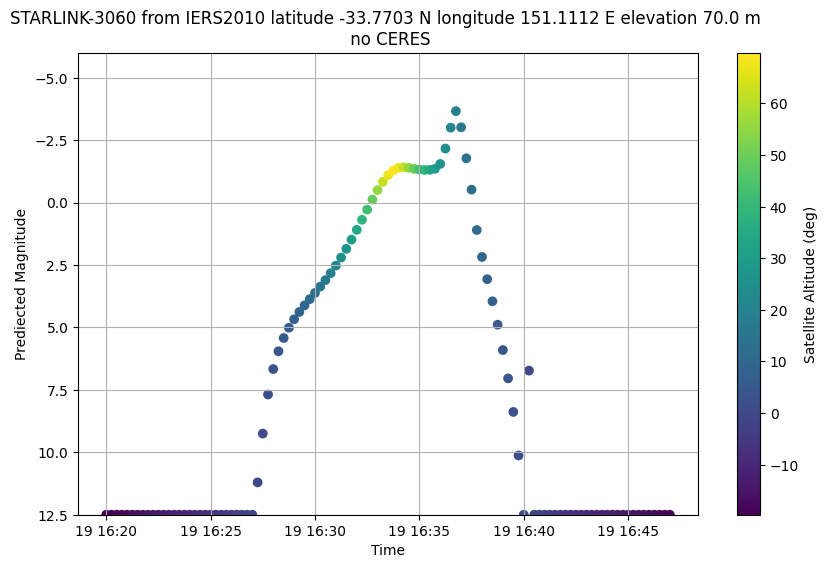

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(times_datetime, magnitudes_lab_brdfs, c = satellite_altitudes)
plt.colorbar(label = "Satellite Altitude (deg)")
#plt.plot(times_datetime, azimuths, label="Azimuth")
plt.xlabel("Time")
plt.ylabel("Prediected Magnitude")
plt.ylim(12.5,-6)
plt.title(f"{satellite.name} from {observer_location} \n no CERES")
plt.grid()
plt.savefig('/Users/physarah/Desktop/test_sat_brightness_plot.png')

<Topos IERS2010 latitude -33.7703 N longitude 151.1112 E elevation 70.0 m>